In [1]:
import wandb
api = wandb.Api()


In [2]:
import numpy as np
# Define the project name and IDs
'''
project_name = "renbotu/fno"
ids = {
    'Baseline+modes64': 'lyff59ic',
    'AMP+HP+tanh+modes64': '8aiug7vh',
    'Baseline+modes32': 'vp056zrl',
    'AMP+HP+tanh+modes32': 'aus0fnzu'
}
'''
project_name = "crwhite/lowprecision"
ids = {
    'Baseline+modes64': 'gnjbaroy',
    'AMP+HP+tanh+modes64': '5nnvhtkm',
    'Baseline+modes32': 'pgyti02y',
    'AMP+HP+tanh+modes32': 'fuxe4vng'
}

ids_seed2 = {
    'Baseline+modes64': '5squto9e',
    'AMP+HP+tanh+modes64': 'nua0wf1u',
    'Baseline+modes32': 'd1ddymyb',
    'AMP+HP+tanh+modes32': 'k17c3wsv'
}


# Define the metrics to extract
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
data_time = {}
data_128_h1 = {}
data_128_h1_seed2 = {}

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_time[method] = np.array(time_data)
    data_128_h1[method] = np.array(h1_data)

for method, exp_id in ids_seed2.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_128_h1_seed2[method] = np.array(h1_data)


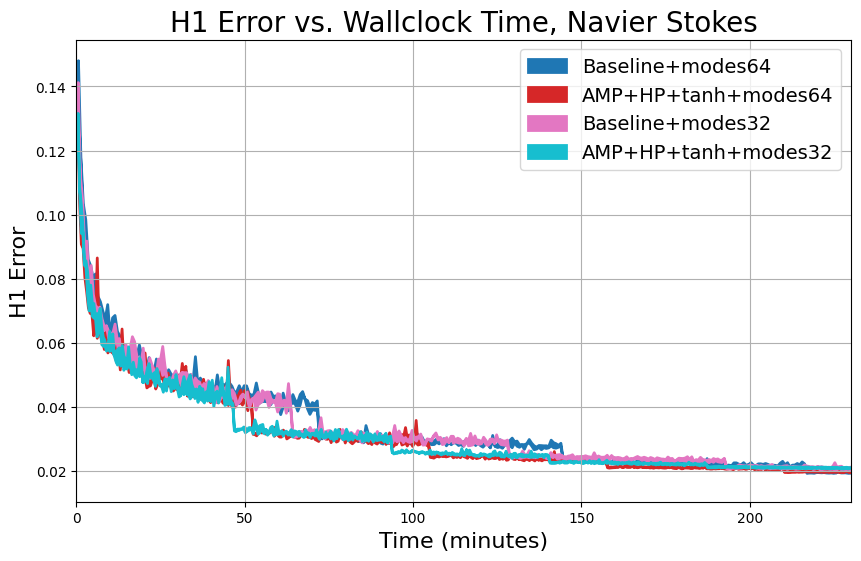

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
def plot_training_curves(data_time, data_losses, data_losses2, methods):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(methods))
    colors = plt.cm.get_cmap('tab10', len(methods))
    line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'x']
    line_widths = [2]*4
    #alphas = [0.8, 1.0, 0.8, 0.7]

    for i, method in enumerate(methods):        
        time = data_time[method]
        losses = data_losses[method]

        losses_seed2 = data_losses2[method]
        max_errors = np.maximum(losses, losses_seed2)
        min_errors = np.minimum(losses, losses_seed2)
        
        cumulative_time = np.nancumsum(time) / 60  # Calculate cumulative time
        #plt.plot(cumulative_time, losses, label=method,  color=colors[i], linestyle=line_styles[i], linewidth=line_widths[i], alpha=alphas[i])
        plt.fill_between(cumulative_time, min_errors, max_errors, label=method,  color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i])


    
    plt.xlabel('Time (minutes)', fontsize=16)
    plt.xlim([0, 230])
    plt.ylabel('H1 Error', fontsize=16)
    plt.title('H1 Error vs. Wallclock Time, Navier Stokes', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.savefig('error_vs_time_navier.pdf', format='pdf')
    plt.show()


methods = ids.keys()

plot_training_curves(data_time, data_128_h1, data_128_h1_seed2, methods)


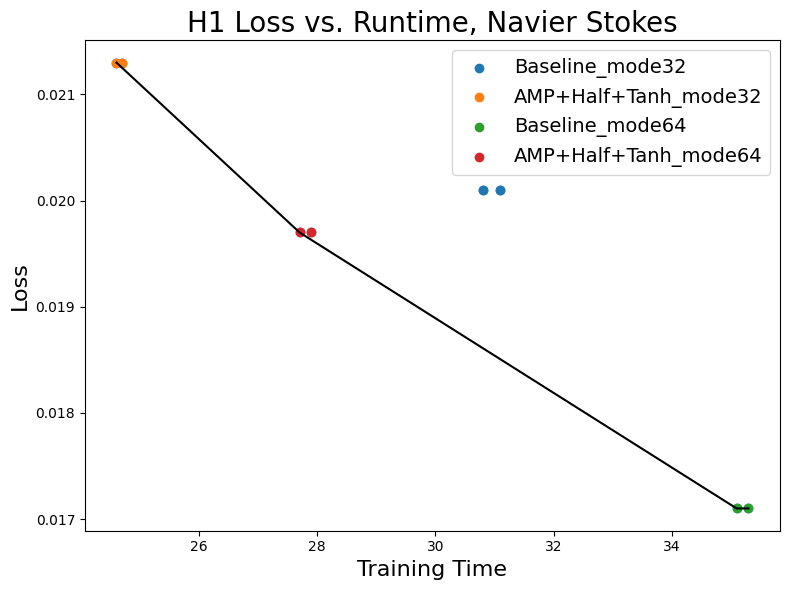

In [4]:


def plot_pareto_curve(training_time, loss, methods):
    plt.figure(figsize=(8, 6))

    # Plot the data points
    plt.scatter(training_time, loss)
    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 5
    additional_idx_1 = 6
    additional_idx_2 = 7

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]],
                              [training_time[additional_idx_1], loss[additional_idx_1]],
                              [training_time[additional_idx_2], loss[additional_idx_2]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', label='Pareto Curve')

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    for i, method in enumerate(methods):
        if method not in method_legend_handles:
            color = plt.cm.tab10(len(method_legend_handles))
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
        plt.scatter(training_time[i], loss[i], color=method_legend_handles[method].get_facecolor()[0])
    
    
    plt.xlabel('Training Time', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('H1 Loss vs. Runtime, Navier Stokes', fontsize=20)
    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14, loc='upper right')
    
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('pareto_curve_v100.pdf', format='pdf')
    plt.show()


# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]
training_time.extend([30.8, 24.6, 35.3, 27.7])
loss.extend([0.0201, 0.0213, 0.0171, 0.0197])

methods = ['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64']
methods.extend(['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64'])

plot_pareto_curve(training_time, loss, methods)


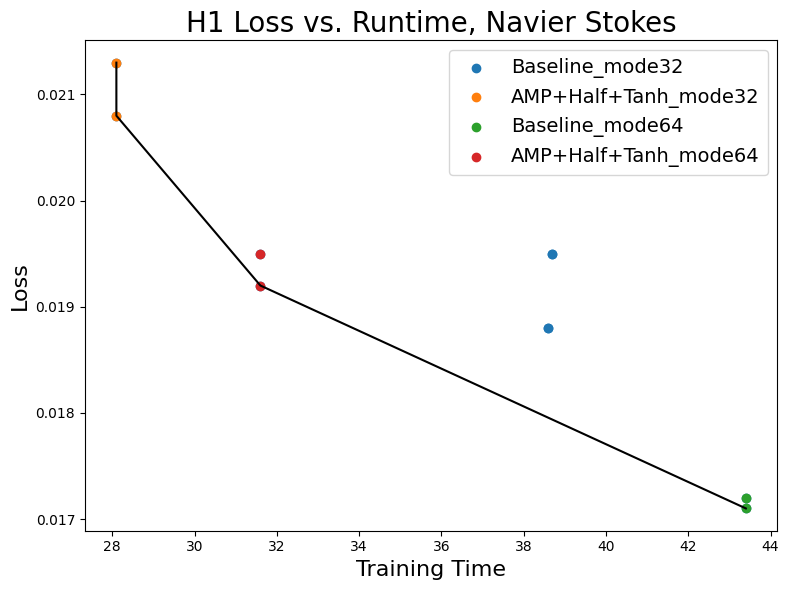

In [5]:

training_time = [38.7, 28.1, 43.4, 31.6, 38.6, 28.1, 43.4, 31.6]
loss = [0.0195, 0.0213, 0.0172, 0.0195, 0.0188, 0.0208, 0.0171, 0.0192 ]
methods = ['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64']
methods.extend(methods)

plot_pareto_curve(training_time, loss, methods)

In [6]:
def plot_runtimes(runtimes, labels):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(runtimes))
    colors = plt.cm.get_cmap('Set3', len(runtimes))

    # Find the index of the slowest method
    slowest_idx = np.argmax(runtimes)
    slowest_time = runtimes[slowest_idx]

    # Calculate speedup percentage for each method
    speedups = [(slowest_time - t) / slowest_time * 100 for t in runtimes]

    # Sort runtimes and labels based on slowest to fastest
    runtimes_sorted, labels_sorted, speedups_sorted = zip(*sorted(zip(runtimes, labels, speedups), reverse=True))

    bars = plt.bar(x, runtimes_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal', fontsize=16)
    plt.xlabel('Methods', fontsize=18)
    plt.ylabel('Runtime (seconds)', fontsize=18)
    plt.title('Runtimes of Methods per Epoch', fontsize=20)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{speedups_sorted[i]:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.savefig('runtimes_v100.pdf', format='pdf')

    plt.show()

# Example usage:
runtimes = [44.44,
42.25,
39.02,
35.63,]
#37.35]
labels = ['Baseline',
'AMP',
'Half-Precision FNO (Half)',
'AMP + Half',]
#'AMP + HP + full-FFT']


#plot_runtimes(runtimes, labels)

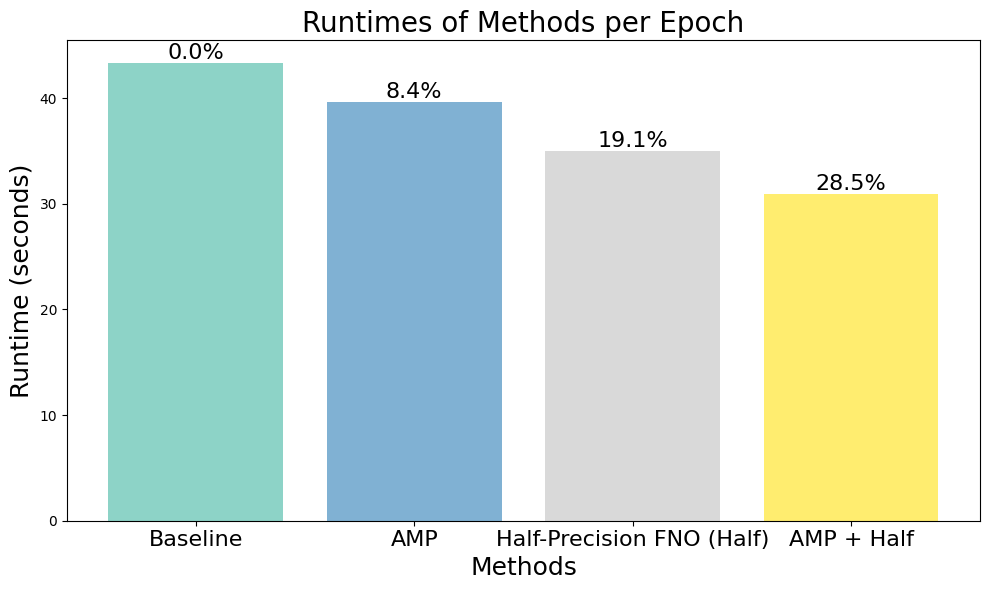

In [7]:
# Example usage:
runtimes = [43.3,
39.65,
35.01,
30.96,]
#37.8]

labels = ['Baseline',
'AMP',
'Half-Precision FNO (Half)',
'AMP + Half',]
#'AMP + HP + full-FFT']

plot_runtimes(runtimes, labels)